<small>This notebook was put together by [wesley beckner](http://wesleybeckner.github.io)</small>


<a id='top'></a>

# Contents

[scrape data](#scrape)

[create descriptors](#descriptors)

[multi-output development model](#multidevmodel)

[multi-output regressor](#multi)

[multi-layer perceptron (MLP) regressor](#nn)

[create static files](#static)

[adaptive learning](#adaptive)

In [69]:
import gains as genetic
from math import inf
import statistics
import dill
import csv
import requests
import json
import pickle
import salty
import numpy as np
from numpy import array, all
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from scipy import stats
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from math import log
from time import sleep
%matplotlib inline
       
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

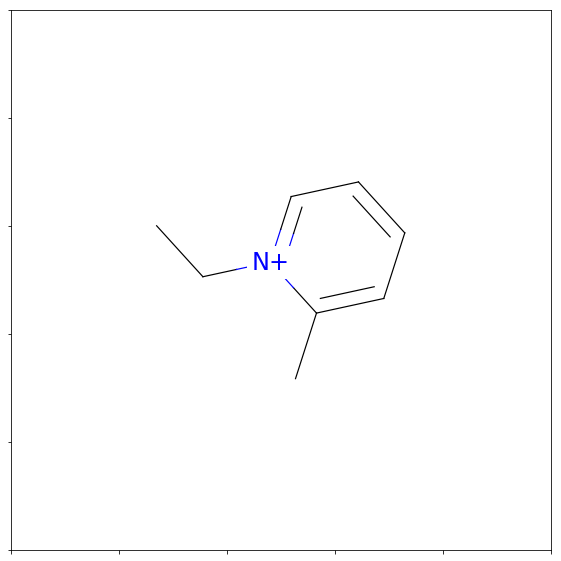

In [84]:
# fig=Draw.MolToMPL(Chem.MolFromSmiles("CC(CC(C)(C)C)CP(=O)([O-])CC(C)CC(C)(C)C"))
fig=Draw.MolToMPL(Chem.MolFromSmiles(salty.check_name("1-ethyl-2-methylpyridinium")))

fig.savefig(filename='../../designer_molecules/1.pdf', 
                       bbox_inches='tight', format='pdf') 

<a id='scrape'></a>

# Scrape ILThermo Data

[back to top](#top)

ILThermo has specific 4-letter tags for the properties in the database. These can be determined by inspecting the web elements on their website.

Melting point: prp=lcRG (note this in the paper_url string)

All that needs to be changed to scrape other property data is the 4-letter tag and the directory in which to save the information.

In [ ]:
paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?"\
    "cmp=&ncmp=1&year=&auth=&keyw=&prp=bvSs"
#viscosity: blXM
#melting temp: lcRG
#heat capacity: bvSs
    
r = requests.get(paper_url)
header = r.json()['header']
papers = r.json()['res']
i = 1
data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
for paper in papers[:]:
    
    r = requests.get(data_url.format(paper_id=paper[0]))
    data = r.json()['data']
    with open("../salty/data/CPT/%s.json" % i, "w") as outfile:
        json.dump(r.json(), outfile)
    #then do whatever you want to data like writing to a file
    sleep(0.5) #import step to avoid getting banned by server
    i += 1

<a id='descriptors'></a>

# Create Descriptors

[back to top](#top)

The scraped data is in the form of a json file. The json files contain all the experimental information NIST has archived, including methods and experimental error!

Unfortunately the IUPAC names in the database are imperfect. We address this after the following cell.

In [4]:
###add JSON files to density.csv
outer_old = pd.DataFrame()
outer_new = pd.DataFrame()
number_of_files = 569

for i in range(569):
    with open("../salty/data/CPT/%s.json" % str(i+1)) as json_file:
        
        #grab data, data headers (names), the salt name
        json_full = json.load(json_file)
        json_data = pd.DataFrame(json_full['data'])
        json_datanames = np.array(json_full['dhead'])
        json_data.columns =  json_datanames
        json_saltname = pd.DataFrame(json_full['components'])

        inner_old = pd.DataFrame()
        inner_new = pd.DataFrame()

        #loop through the columns of the data, note that some of the 
        #json files are missing pressure data. 
        if len(json_data.columns.values) > 3:
            print(json_data.columns.values)
        for indexer in range(len(json_data.columns)):
            grab=json_data.columns[indexer]
            list = json_data[grab]
            #my_list grabs first element
            #change l[0] to l[1] for error
            my_list = [l[0] for l in list]
            dfmy_list = pd.DataFrame(my_list)
            dfmy_list.columns = [json_datanames[indexer][0]]
            inner_new = pd.concat([dfmy_list, inner_old], axis=1)
            inner_old = inner_new

        #add the name of the salt    
        inner_old['salt_name']=json_saltname.iloc[0][3]           

        #add to the growing dataframe
        outer_new = pd.concat([inner_old, outer_old], axis=0)
        outer_old = outer_new
pd.DataFrame.to_csv(outer_old, path_or_buf='../salty/data/cpt.csv', index=False)

We can view an example of the raw data:

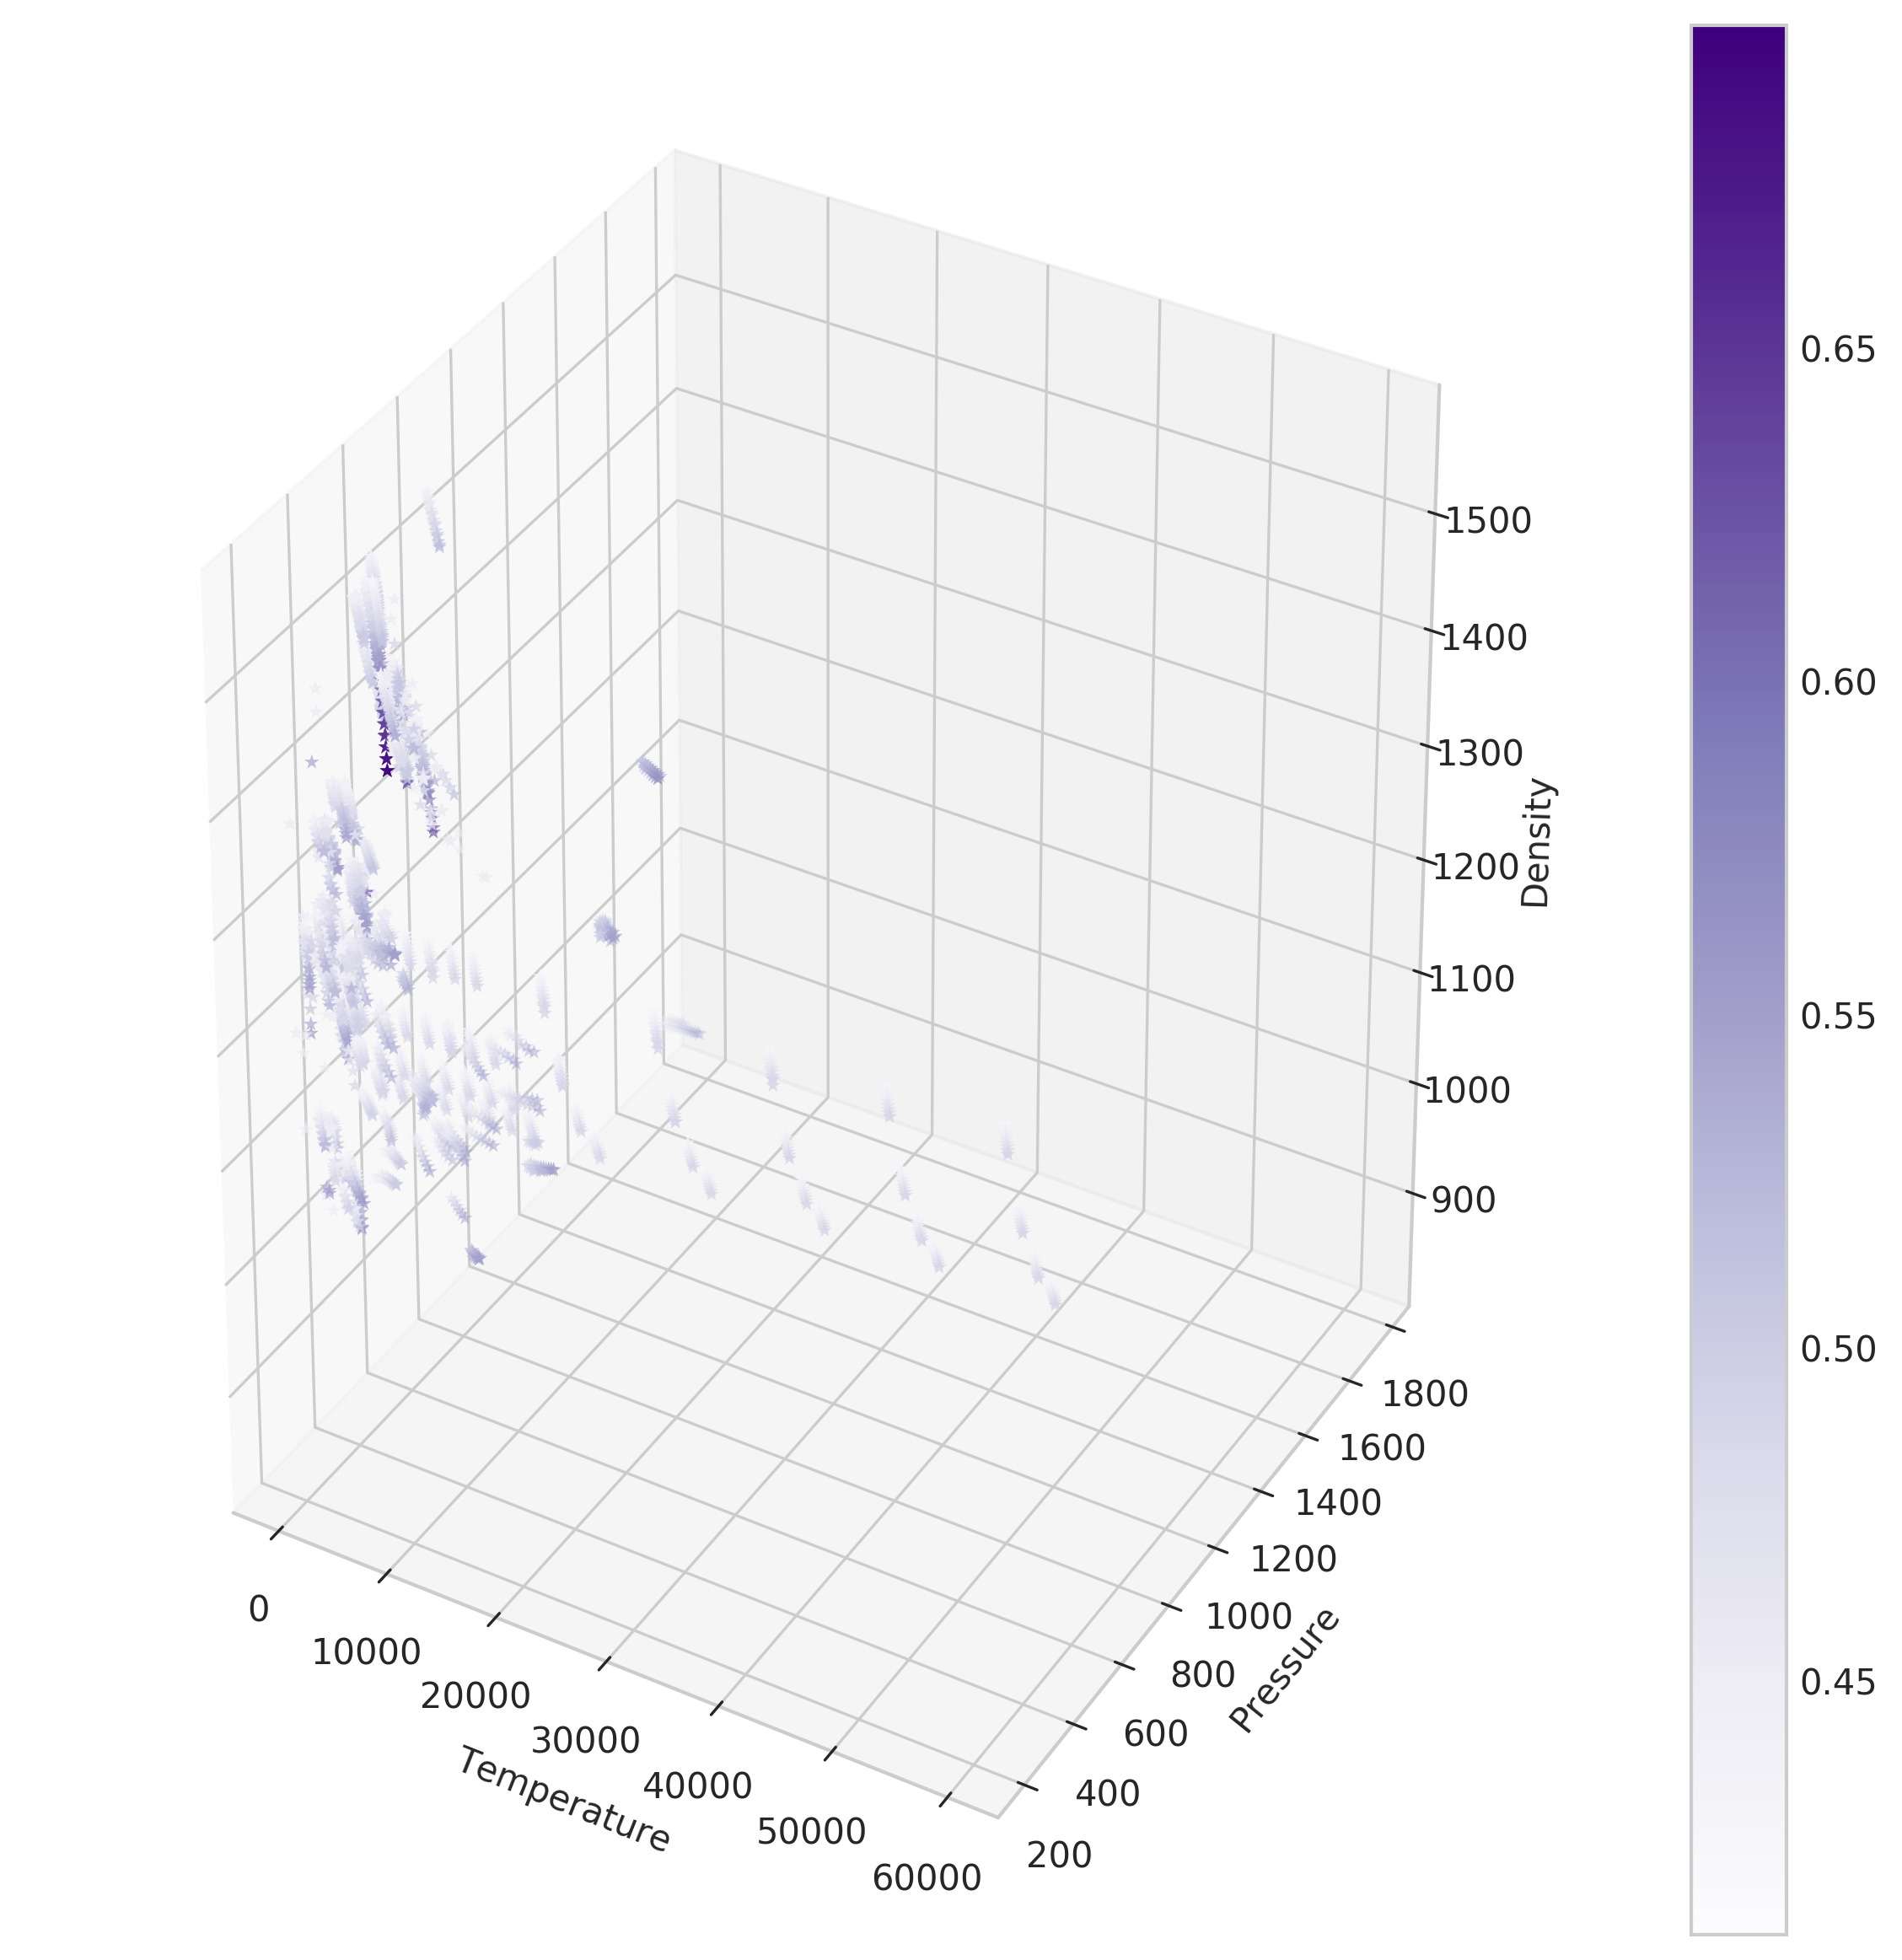

In [119]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# if you're loading in a previous file uncomment
#df = pd.read_csv('../salty/data/density.csv',delimiter=',')
cols = df.columns
#cols = outer_old.columns
#df = outer_old.loc[outer_old["salt_name"] == "1-ethyl-3-methylimidazolium tetrafluoroborate"]
# df = df[cols[[1,2,3]]]
# df = df.astype(float)
#print(df.describe())

# df.reset_index(inplace=True, drop=True)
#df.boxplot()
#df.dtypes

with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(10,10), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter(df["Pressure, kPa"],df["Heat capacity at constant pressure, J/K/mol"] ,
            df["Specific density, kg/m<SUP>3</SUP>"],linewidth=0,marker="*",
           c=df["Temperature, K"]/max(df["Temperature, K"]),cmap="Purples")
    plt.colorbar(scat)
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Pressure')
    ax.set_zlabel('Density')

Dealing with messy data is commonplace. *Even highly vetted data in ILThermo.*

I addressed inaccuracies in the IUPAC naming by first parsing the IUPAC names into two strings (caiton and anion) and then hand checking the strings that had more than two components. I then matched these **weird** IUPAC names to their correct SMILES representations. These are stored in the salty database file cationInfo.csv and anionInfo.csv.

In [22]:
df = pd.read_csv('../salty/data/cpt.csv',delimiter=',')
salts = pd.DataFrame(df["salt_name"])
salts = salts.rename(columns={"salt_name": "salts"})
anions= []
cations= []
missed = 0
for i in range(df.shape[0]):
    if len(salts['salts'].iloc[i].split()) == 2:
        cations.append(salts['salts'].iloc[i].split()[0])
        anions.append(salts['salts'].iloc[i].split()[1])
    elif len(salts['salts'].iloc[i].split()) == 3:
        if("sulfate" in salts['salts'].iloc[i] or\
        "phosphate" in salts['salts'].iloc[i] or\
        "phosphonate" in salts['salts'].iloc[i] or\
        "carbonate" in salts['salts'].iloc[i]):
            #these strings have two-word anions
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            cations.append(salts['salts'].iloc[i].split()[0])
            anions.append(first + ' ' + second)
        elif("1:1" in salts["salts"].iloc[i]):
            #some strings contain the mixing ratio
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first)
            anions.append(second)
        elif("(OC-6-11)-hexafluoroantimonate(1-)" in salts["salts"].iloc[i]):
            #special case
            cations.append("1-butyl-3-methylimidazolium")
            anions.append("hexafluoroantimonate")
        elif("1,3-propanediol, 2-amino-2-(hydroxymethyl)-," in salts["salts"].iloc[i]):
            #special case
            cations.append("2-amino-2-(hydroxymethyl)-1,3-propanediol")
            anions.append("hydrochloride")
        else:
            #assume the rest are two-word cations
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            cations.append(first + ' ' + second)
            anions.append(third)
    elif len(salts['salts'].iloc[i].split()) == 4:
        #this particular string block contains (1:1) at end of name
        if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first + ' ' + second)
            anions.append(salts['salts'].iloc[i].split()[2])
        else:
            #and two word anion
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            anions.append(first + ' ' + second)
            cations.append(salts['salts'].iloc[i].split()[0])
    elif("2-aminoethanol-2-hydroxypropanoate" in salts['salts'].iloc[i]):
        #one of the ilthermo salts is missing a space between cation/anion
        anions.append("2-hydroxypropanoate")
        cations.append("2-aminoethanol")
    elif len(salts['salts'].iloc[i].split()) == 5:
        if("bis[(trifluoromethyl)sulfonyl]imide" in salts['salts'].iloc[i]):
            anions.append("bis(trifluoromethylsulfonyl)imide")
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            fourth = salts['salts'].iloc[i].split()[3]
            cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
        if("trifluoro(perfluoropropyl)borate" in salts['salts'].iloc[i]):
            anions.append("trifluoro(perfluoropropyl)borate")
            cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")
    elif("1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)"
        in salts['salts'].iloc[i]):
        anions.append("trifluoroacetic acid")
        cations.append("1-ethyl-3-methyl-1H-imidazolium")
    elif("L-alanine, 1-methylethyl ester, dodecyl sulfate (1:1)"
        in salts['salts'].iloc[i]):
        anions.append("dodecyl sulfate")
        cations.append("L-alanine, 1-methylethyl ester")
    elif("difluorogermylene" in salts['salts'].iloc[i]):
        anions.append("difluoro")
        cations.append("germylene")
    else:
        print(salts['salts'].iloc[i])
        missed += 1
anions = pd.DataFrame(anions, columns=["name-anion"])
cations = pd.DataFrame(cations, columns=["name-cation"])
# salts=pd.read_csv('../salty/data/salts_with_smiles.csv',delimiter=',')
# new_df = pd.concat([salts["name-cation"], salts["name-anion"], salts["Temperature, K"],\
#                     salts["Pressure, kPa"], salts["Specific density, kg/m<SUP>3</SUP>"]],\
#                    axis = 1)
print(missed)

0


After appending SMILES to the dataframe, we're ready to add RDKit descriptors. Because the descriptors are specific to a given cation and anion, and there are many repeats of these within the data (~10,000 datapoints with ~300 cations and ~150 anions) it is much faster to use pandas to append existing descriptor dataframes to our growing dataframe from ILThermo.

In [23]:
cationDescriptors = salty.load_data("cationDescriptors.csv")
cationDescriptors.columns = [str(col) + '-cation' for col in cationDescriptors.columns]
anionDescriptors = salty.load_data("anionDescriptors.csv")
anionDescriptors.columns = [str(col) + '-anion' for col in anionDescriptors.columns]

In [27]:
new_df = pd.concat([cations, anions, df["Temperature, K"], df["Pressure, kPa"],\
                    df["Heat capacity at constant pressure, J/K/mol"]], axis=1)
new_df = pd.merge(cationDescriptors, new_df, on="name-cation", how="right")
new_df = pd.merge(anionDescriptors, new_df, on="name-anion", how="right")
new_df.dropna(inplace=True) #remove entries not in smiles database

In [28]:
pd.DataFrame.to_csv(new_df, path_or_buf='../salty/data/MODELS/cpt_premodel.csv', index=False)

<a id='multidevmodel'></a>
# Multi-Output Development Model

[back to top](#top)

**At this point I introduce a new class of objects called devmodel. **

devmodel is a pickle-able object. self.Data contains the scaled/centered feature data and log of the property data as well as the original IUPAC names and SMILES. This makes it easy to consistently unpickle the devmodel and begin using it in an sklearn algorithm without making changes to the dataframe. Self.Coef_data contains the mean and standard deviation of the features so that structure candidates in our genetic algorithm can be scaled and centered appropriately.

It is important to make any addition subselections of the dataset before you scale and center the data - this is the purpose of the cells bellow.

In [23]:
dill_out = open("../salty/data/MODELS/cpt_density_devmodel.pkl", "wb")
dill.dump(lets_see_then, dill_out)
dill_out.close()

In [63]:
#data_ranges = [[231.8, 1764.1],[0.00316, 10.21],[847.5, 1557.1]]#
# data = ['cpt']#, 'density']
# T = [298, 302]
# P = [101, 102]
data = salty.aggregate_data(['cpt'])
data.Data_summary

,0
Unique salts,186
Cations,"array(['CCCC[n+]1ccc(cc1)C', 'CCCCn1cc[n+](c1C..."
Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
Total datapoints,15136
cpt,0.294 - 9160.0
Temperature range (K),100.0 - 60000.0
Pressure range (kPa),4.82 - 663.1


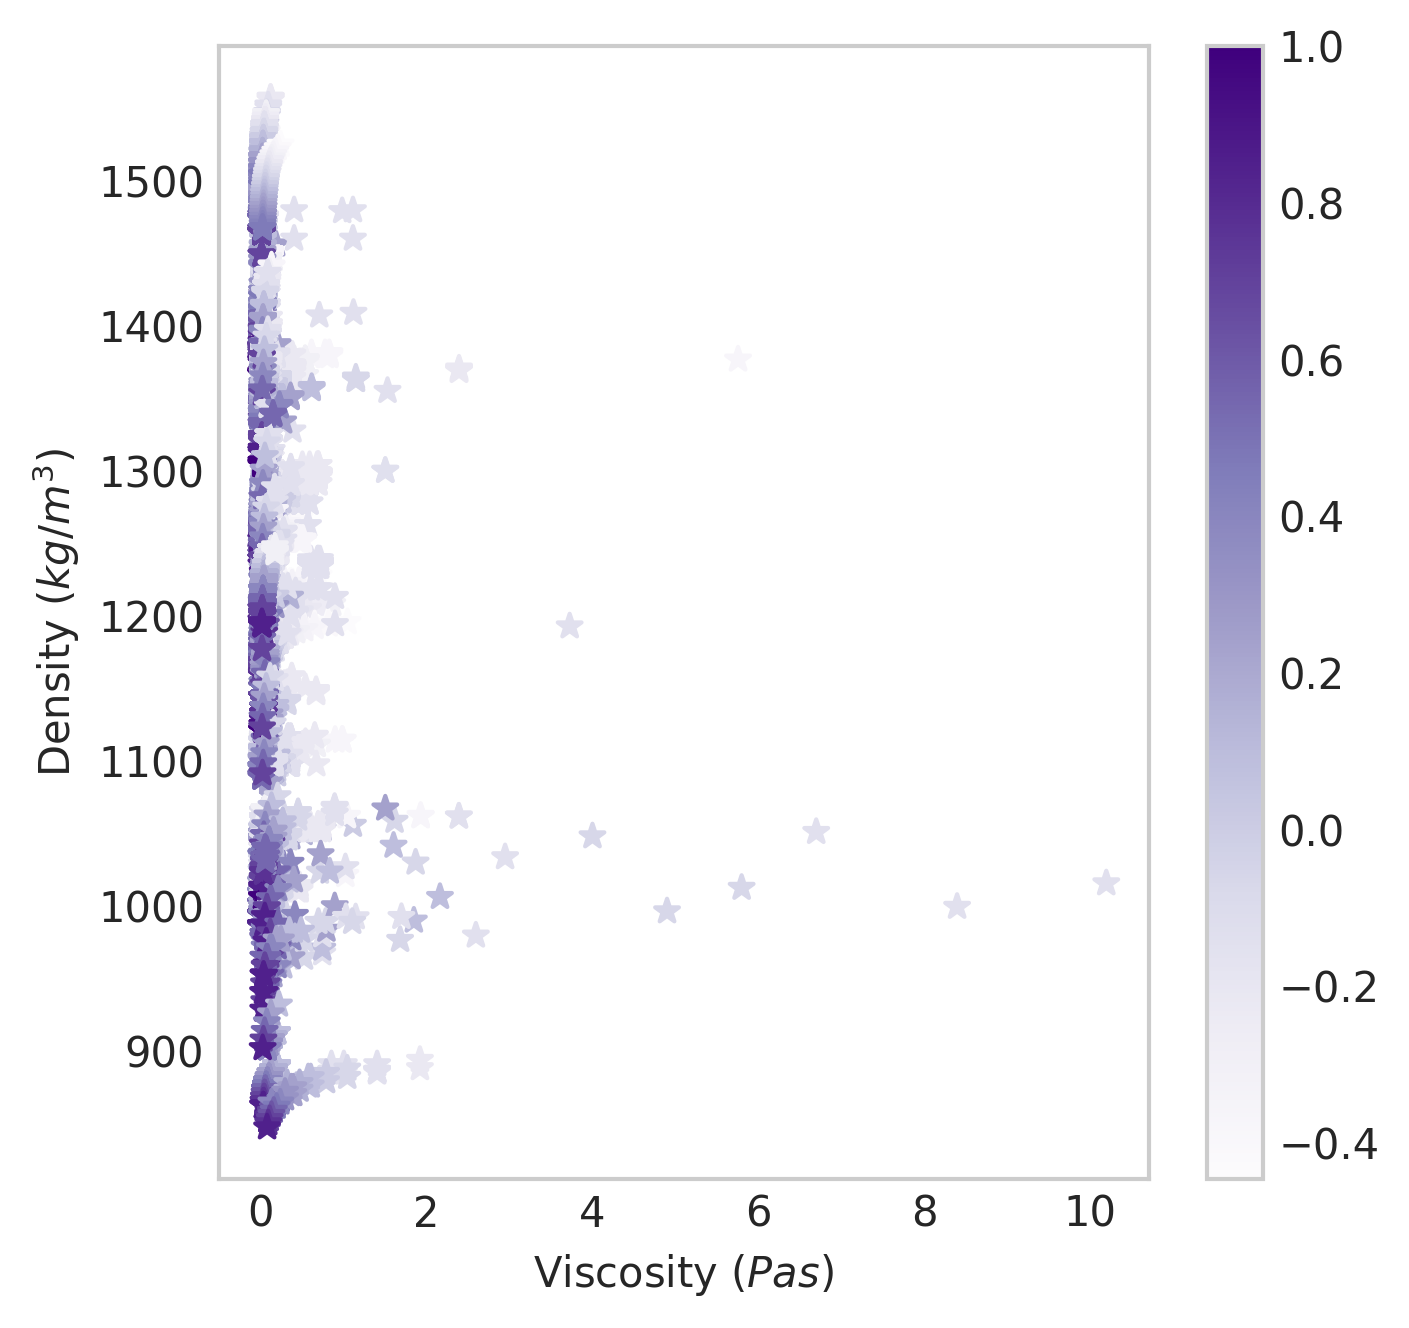

In [320]:
df = lets_see_then.Data
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    scat = ax.scatter(df["Viscosity, Pa&#8226;s"], df["Specific density, kg/m<SUP>3</SUP>"],
        marker="*", c=df["Temperature, K"]/max(df["Temperature, K"]), cmap="Purples")
    plt.colorbar(scat)
    ax.grid()
#     ax.set_axis_off()
    ax.set_ylabel("Density $(kg/m^3)$")
    ax.set_xlabel("Viscosity $(Pas)$")
#     ax.set_xlim(0,.1)
#     ax.set_ylim(0,2)
#     ax.text(0.1,.9,"R: {0:10.3f}".format(model.score(X,Y)), transform = ax.transAxes)
# fig.savefig(filename='../../designer_molecules/multi2.pdf', 
#                        bbox_inches='tight', format='pdf', transparent=False) 

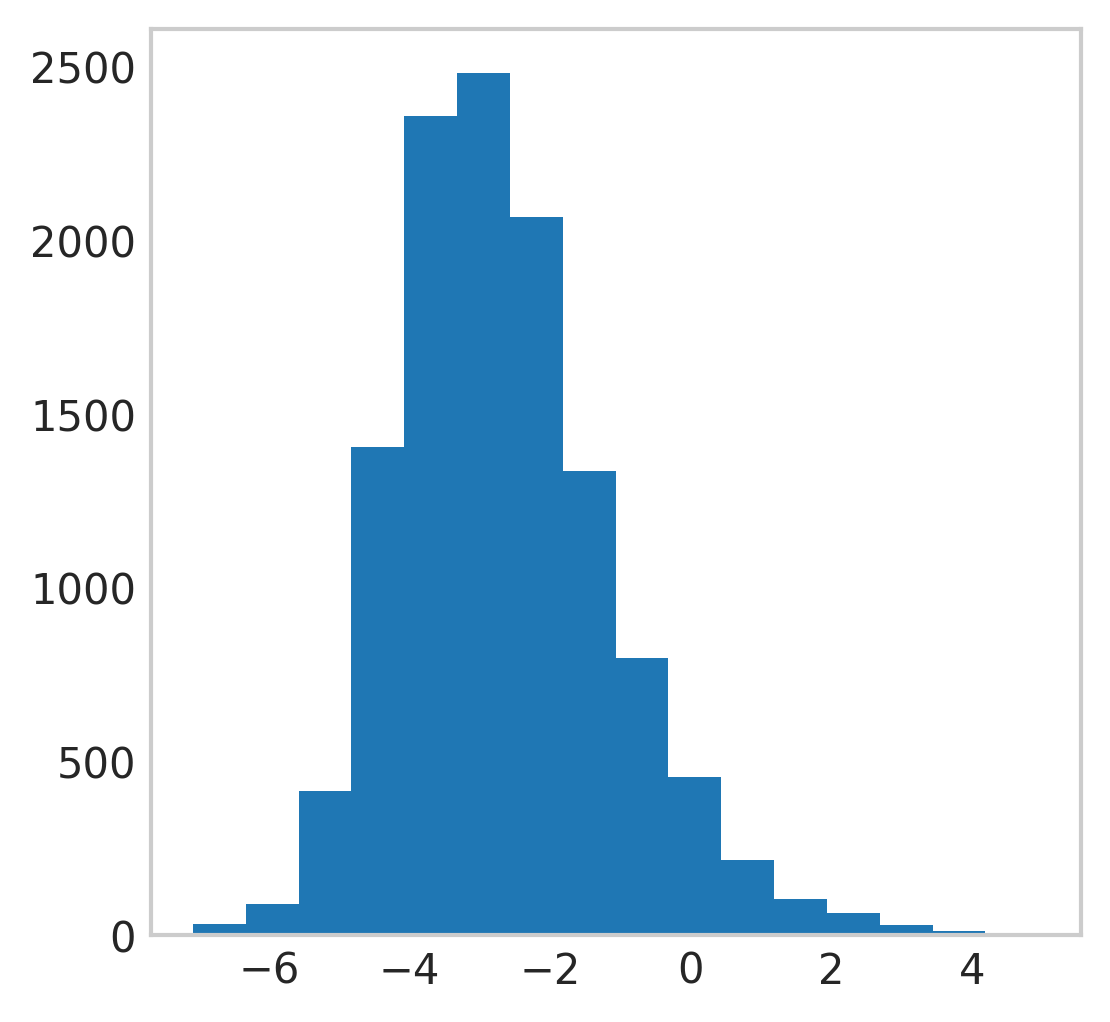

In [80]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(4,4), dpi=300)
    ax=fig.add_subplot(111)
    ax.hist(df["Viscosity, Pa&#8226;s"], bins=16)
#     plt.xlabel("Density $kg/m^3$")
    ax.grid()
#     ax.set_xlim(0,2)
#     ax.set_ylim(0,2)
# fig.savefig(filename='../../designer_molecules/dens_hist.pdf', 
#                        bbox_inches='tight', format='pdf') 

<a id='multi'></a>

# Multi Output Regressor

[back to top](#top)

In [13]:
import salty
import numpy as np
#name = salty.aggregate_data(['cpt'])
X, Xt, Y, Yt = devmodel_to_array(name)

In [17]:
Yt

array([], shape=(0, 1), dtype=float64)

In [10]:
def devmodel_to_array(model_name,train_fraction=1):
    if model_name is str:
        model_outputs = len(model_name.split("_"))
        pickle_in = open("../salty/data/MODELS/%s_devmodel.pkl" % model_name, "rb")
        devmodel = dill.load(pickle_in)
    else:
        model_outputs = -6 + model_name.Data_summary.shape[0]
        devmodel = model_name
    rawdf = devmodel.Data
    rawdf = rawdf.sample(frac=1)
    metadf = rawdf.select_dtypes(include=["object"])
    datadf = rawdf.select_dtypes(include=[np.number])

    data=np.array(datadf)

    n = data.shape[0]
    d = data.shape[1]
    d -= model_outputs
    n_train = int(n*train_fraction) #set fraction of data to be for training
    n_test  = n - n_train

    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train,model_outputs))
    Y_test = np.zeros((n_test,model_outputs))
    X_train[:] = data[:n_train,:-model_outputs] #fill arrays according to train/test split
    Y_train[:] = (data[:n_train,-model_outputs:].astype(float))
    X_test[:] = data[n_train:,:-model_outputs]
    Y_test[:] = (data[n_train:,-model_outputs:].astype(float))
    return X_train, Y_train, X_test, Y_test

In [70]:
property_models = ["cpt_viscosity_density", "cpt_density",
                   "viscosity_density", "cpt_viscosity"]
for i, name in enumerate(property_models):
    X_train, Y_train, X_test, Y_test = devmodel_to_array(name)
    print(cross_val_score(model, X_train, Y_train, cv=5))

/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages

[ 0.96344986  0.96109263  0.94915832  0.9354056   0.94959264]


/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages

[ 0.99214561  0.99450075  0.994264    0.99288016  0.9949078 ]


/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages

[ 0.98665024  0.98775225  0.98257892  0.98589726  0.98820868]


In [71]:
model_scores = [[ 0.98261336,  0.98244677,  0.98313889,  0.98245015,  0.98240316],
[ 0.98297343,  0.98269192,  0.98497888,  0.98737214,  0.98591271],
[ 0.99186152,  0.99120321,  0.98881741,  0.99070989,  0.99094503],
[ 0.98689279,  0.98280267,  0.98243339,  0.98395326,  0.93045875],
[ 0.96344986,  0.96109263,  0.94915832,  0.9354056,   0.94959264],
[ 0.99214561,  0.99450075,  0.994264,    0.99288016,  0.9949078 ],
[ 0.98665024,  0.98775225,  0.98257892,  0.98589726,  0.98820868]
]
for i in range(len(model_scores)):
    print(np.mean(model_scores[i]), np.std(model_scores[i]))

0.982610466 0.000273756708382
0.984785816 0.00177004966598
0.990707412 0.00102042706225
0.973308172 0.0214818425946
0.95173981 0.0100267777367
0.993739664 0.00104866363871
0.98621747 0.00199245262589


In [69]:
#Density Model Settings
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
#Viscosity Model Settings
# model = MLPRegressor(activation='tanh', alpha=0.65795591411979337, batch_size='auto',
#        beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=25, learning_rate='invscaling',
#        learning_rate_init=0.001, max_iter=100000, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=None,
#        shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
#        verbose=False, warm_start=False)

In [12]:
multi_model = MultiOutputRegressor(model)
multi_model.fit(X_train,Y_train)
multi_model.score(X_train,Y_train)

0.98574784202610477

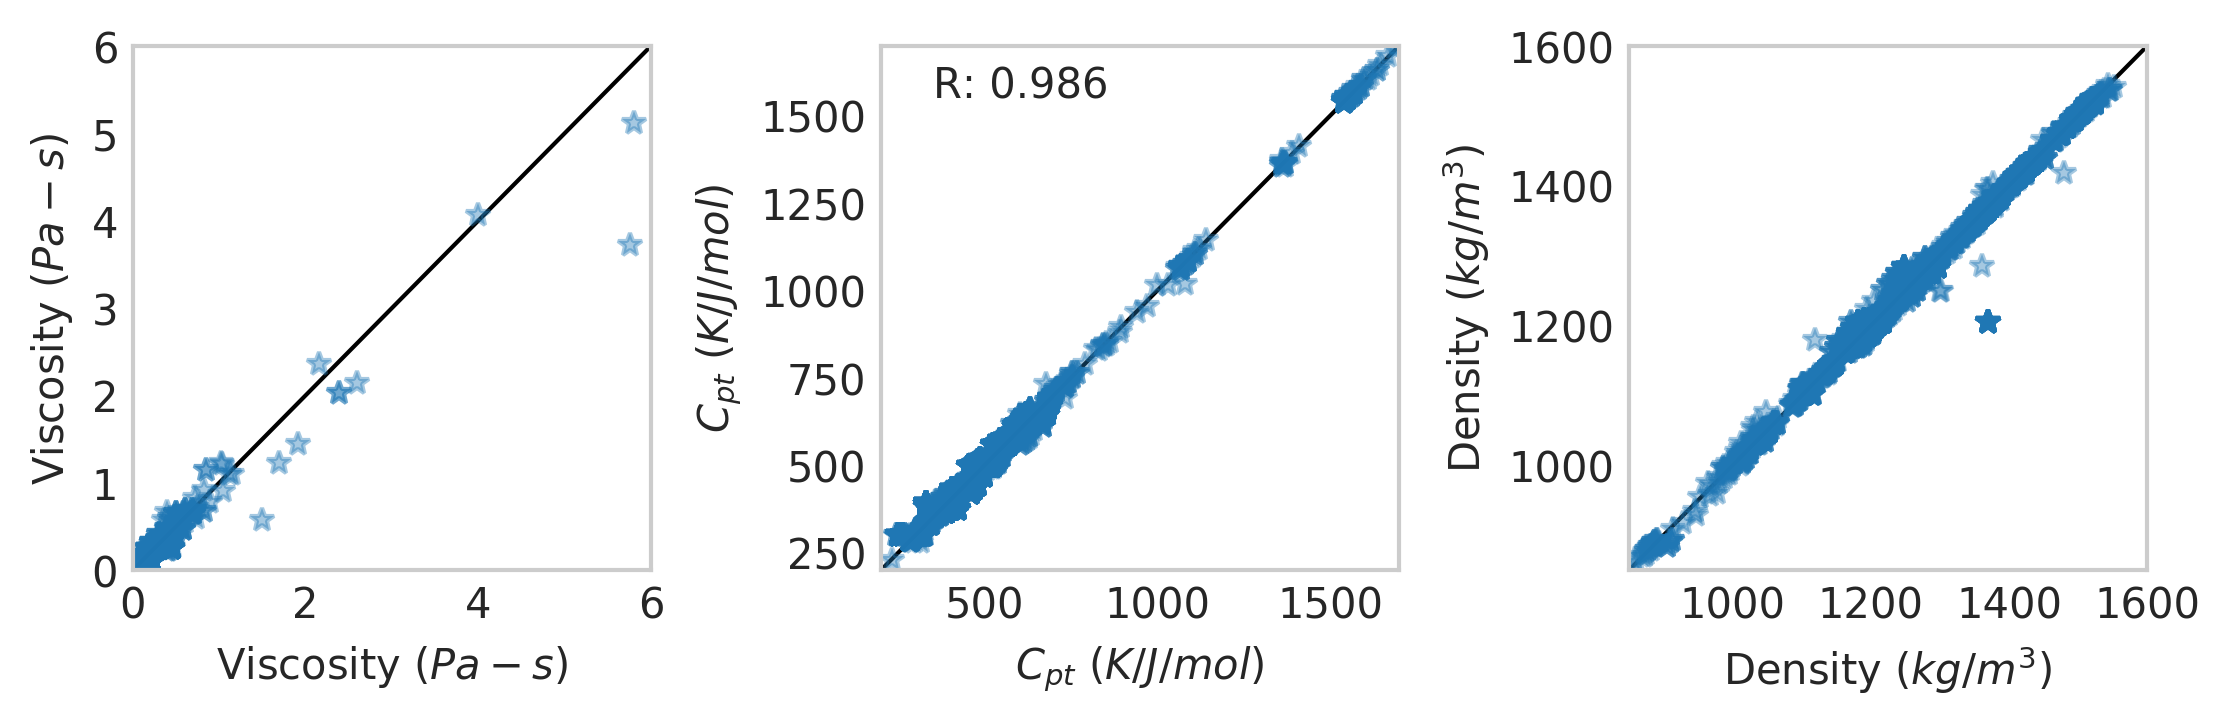

In [49]:
X=X_test
Y=Y_test
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(7.5,2.5), dpi=300)
    ax=fig.add_subplot(132)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,0],np.exp(multi_model.predict(X))[:,0],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("$C_{pt}$ $(K/J/mol)$")
    ax.set_xlabel("$C_{pt}$ $(K/J/mol)$")
    ax.text(0.1,.9,"R: {0:5.3f}".format(multi_model.score(X,Y)), transform = ax.transAxes)
    plt.xlim(200,1700)
    plt.ylim(200,1700)
#     ax.set_yticks(np.arange(800,1800,200))
    ax.grid()
    ax=fig.add_subplot(131)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,1],np.exp(multi_model.predict(X))[:,1],\
            marker="*",linestyle="",alpha=0.4)
    
    ax.set_ylabel("Viscosity $(Pa-s)$")
    ax.set_xlabel("Viscosity $(Pa-s)$")
    plt.xlim(0,6)
    plt.ylim(0,6)
#     ax.set_yticks(np.arange(250,1750,250))
    ax.grid()
    ax=fig.add_subplot(133)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,2],np.exp(multi_model.predict(X))[:,2],\
            marker="*",linestyle="",alpha=0.4)
    
    ax.set_ylabel("Density $(kg/m^3)$")
    ax.set_xlabel("Density $(kg/m^3)$")
    plt.xlim(850,1600)
    plt.ylim(850,1600)
#     ax.set_yticks(np.arange(750,1750,250))
    ax.grid()
#     ax.set_xlim(0,2)
#     ax.set_ylim(0,2)
    
    plt.tight_layout()
fig.savefig(filename='../../designer_molecules/multi4.pdf', 
                       bbox_inches='tight', format='pdf') 

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

In [26]:
import salty
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.rdmolfiles import MolToPDBFile

data = ['cpt', 'density'] #pull raw data from cpt.csv and density.csv
T = [298, 299] #select narrow state variable ranges
P = [101, 102] #we will set MD simulation to 101 kPa and 298 K
devmodel = salty.aggregate_data(data,T=T,P=P)
print(devmodel.Data_summary)
salts = (devmodel.Data["smiles-cation"]+"."+devmodel.Data["smiles-anion"]).unique() #grab the unique salts

for i in range(len(salts[:1])):
    cation = Chem.MolFromSmiles(salts[0].split(".")[0])
    anion = Chem.MolFromSmiles(salts[0].split(".")[1]) #grab cation/anion
    cation = Chem.AddHs(cation) #add Hs
    Chem.EmbedMolecule(cation, Chem.ETKDG()) #Geo optimization for coordinates
    Chem.UFFOptimizeMolecule(cation) #FF optimization for better coordinates
    anion = Chem.AddHs(anion)
    Chem.EmbedMolecule(anion, Chem.ETKDG())
    Chem.UFFOptimizeMolecule(anion)
    
    if i < 10:
        MolToPDBFile(cation,"C0{}.pdb".format(i)) #write pdb files somewhere
        MolToPDBFile(anion,"A0{}.pdb".format(i)) #with 3 character naming scheme
    else:
        MolToPDBFile(cation,"C{}.pdb".format(i)) 
        MolToPDBFile(anion,"A{}.pdb".format(i))

                                                                       0
Unique salts                                                          82
Cations                array(['CCCC[n+]1ccc(cc1)C', 'CCCCCCCCn1cc[n+]...
Anions                 array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',...
Total datapoints                                                    1630
density                                                   885.3 - 1551.8
cpt                                                       207.5 - 1635.0
Temperature range (K)                                  101.325 - 101.325
Pressure range (kPa)                                       298.1 - 298.2


In [75]:
property_model = "cpt_density"
pickle_in = open("../salty/data/MODELS/%s_devmodel.pkl" % property_model, "rb")
devmodel = dill.load(pickle_in)
rawdf = devmodel.Data
rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])

data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

I usually optimize my MLP regressor hyper parameters with any new type of dataset. This takes a long time to run so I use the Hyak supercomputer.

In [73]:
###Randomized Search NN Characterization
param_grid = {"activation": ["identity", "logistic", "tanh", "relu"],\
             "solver": ["lbfgs", "sgd", "adam"], "alpha": sp_rand(),\
             "learning_rate" :["constant", "invscaling", "adaptive"],\
             "hidden_layer_sizes": [randint(100)]}

model = MLPRegressor(max_iter=100000, tol=1e-8)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,\
                          n_jobs=-1, n_iter=10)
grid_result = grid.fit(X_train, Y_train)

print(grid_result.best_estimator_)

/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='tanh', alpha=0.65795591411979337, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=25, learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [152]:
#Density Model Settings
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
#Viscosity Model Settings
# model = MLPRegressor(activation='tanh', alpha=0.65795591411979337, batch_size='auto',
#        beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=25, learning_rate='invscaling',
#        learning_rate_init=0.001, max_iter=100000, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=None,
#        shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
#        verbose=False, warm_start=False)
model.fit(X_train,Y_train)
model.score(X_train,Y_train)

0.9949135274646107

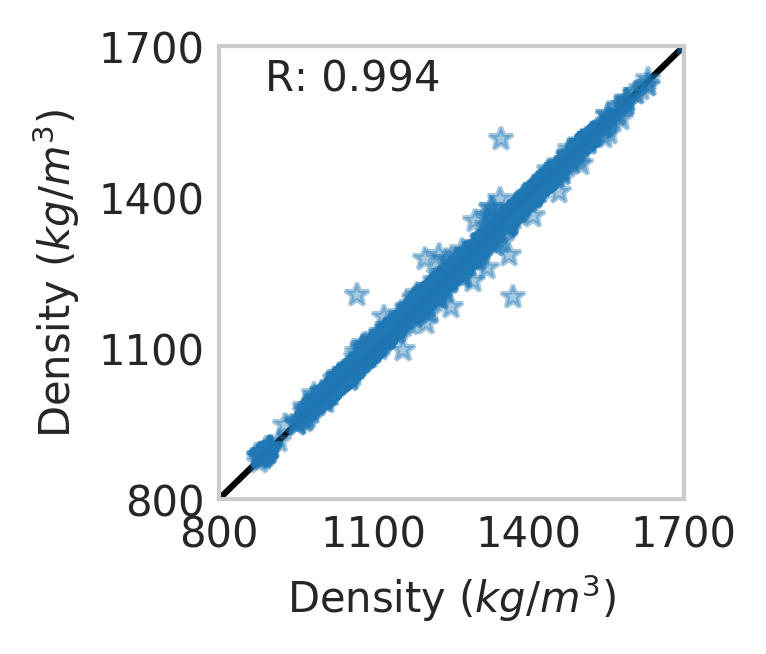

In [156]:
X=X_test
Y=Y_test
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(2,2), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black")
    ax.plot(np.exp(Y),np.exp(model.predict(X)),\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Density $(kg/m^3)$")
    ax.set_xlabel("Density $(kg/m^3)$")
#     ax.set_ylabel("$C_{pt}$ $(J/K/mol)$")
#     ax.set_xlabel("$C_{pt}$ $(J/K/mol)$")
#     ax.set_xlim(0,2100)
#     ax.set_ylim(0,2100)
    ax.grid()
    plt.xticks(np.arange(800,1800,300))
    plt.yticks(np.arange(800,1800,300))
    
    ax.text(0.1,.9,"R: {0:5.3f}".format(model.score(X,Y)), transform = ax.transAxes)
    plt.xlim(800,1700)
    plt.ylim(800,1700)
fig.savefig(filename='../../designer_molecules/single1.pdf', 
                   bbox_inches='tight', format='pdf') 

<a id='static'></a>

# Save the final model to be used in the [GAINS](https://github.com/wesleybeckner/gains) fitness test

[back to top](#top)

In [77]:
model = multi_model

In [84]:
pickle_out = open("../salty/data/MODELS/cpt_density_m1.sav", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

summ = devmodel.Data_summary
a = pd.DataFrame.from_dict(model.get_params(), orient='index')
b = pd.DataFrame([model.score(X_train,Y_train)], columns=["train score"])
c = pd.DataFrame([model.score(X_test,Y_test)], columns=["test score"])
d = pd.concat([summ, a, b.T, c.T])
pd.DataFrame.to_csv(d, path_or_buf=
                   '../salty/data/MODELS/cpt_density_m1_summary.csv', index=True)
coeffs = devmodel.Coef_data
pd.DataFrame.to_csv(coeffs, path_or_buf=
                    '../salty/data/MODELS/cpt_density_m1_descriptors.csv', index=False)

In [39]:
df = pd.read_csv("../salty/data/MODELS/density_m3_summary.csv")

<a id='adaptive'></a>

# Adaptive Learning

[back to top](#top)

In [3]:
cations = eval(pd.read_csv("../salty/data/MODELS/cpt_density_m1_summary.csv").iloc[1][1])

In [77]:
out = pd.DataFrame()
densities = ["1100", "1300", "1500"]
for k, l in enumerate(densities):
    for j in np.arange(40,100,10):
        df = pd.read_csv("../../designer_molecules/pdb_files/model_3/%skgm3/%s/salt_log.csv" % (l,j)) #or salt_candidates
        inner = pd.DataFrame()
        for i in range(1,26):
            if i < 10:
                CAT_ID = "C0%s" % i
                AN_ID = "A0%s" % i
            else:
                CAT_ID = "C%s" % i
                AN_ID = "A%s" % i
            Salt_ID = CAT_ID + "_" + AN_ID
            try:
                mean = np.round(pd.read_csv("../../designer_molecules/pdb_files/model_3/%skgm3/%s/%s.dens" % (l, j, Salt_ID)).describe().loc["mean"][1])
                std = np.round(pd.read_csv("../../designer_molecules/pdb_files/model_3/%skgm3/%s/%s.dens" % (l, j, Salt_ID)).describe().loc["std"][1])
                value = ("{}{}{}".format(mean," +/- ", std))
                true = df.loc[df["Salt ID"] == Salt_ID, "Model Density"]
                difference = (true - mean)/true*100
                df.loc[df["Salt ID"] == Salt_ID, "MD Density"] = value
                df.loc[df["Salt ID"] == Salt_ID, "Error"] = difference #this is % Difference in old version
            except:
                pass
        df.dropna(inplace=True)
        out = pd.concat([df, out], axis=0) 
    out.reset_index(drop=True, inplace=True)
out.shape

(127, 9)

In [78]:
out.to_csv("temp.csv")

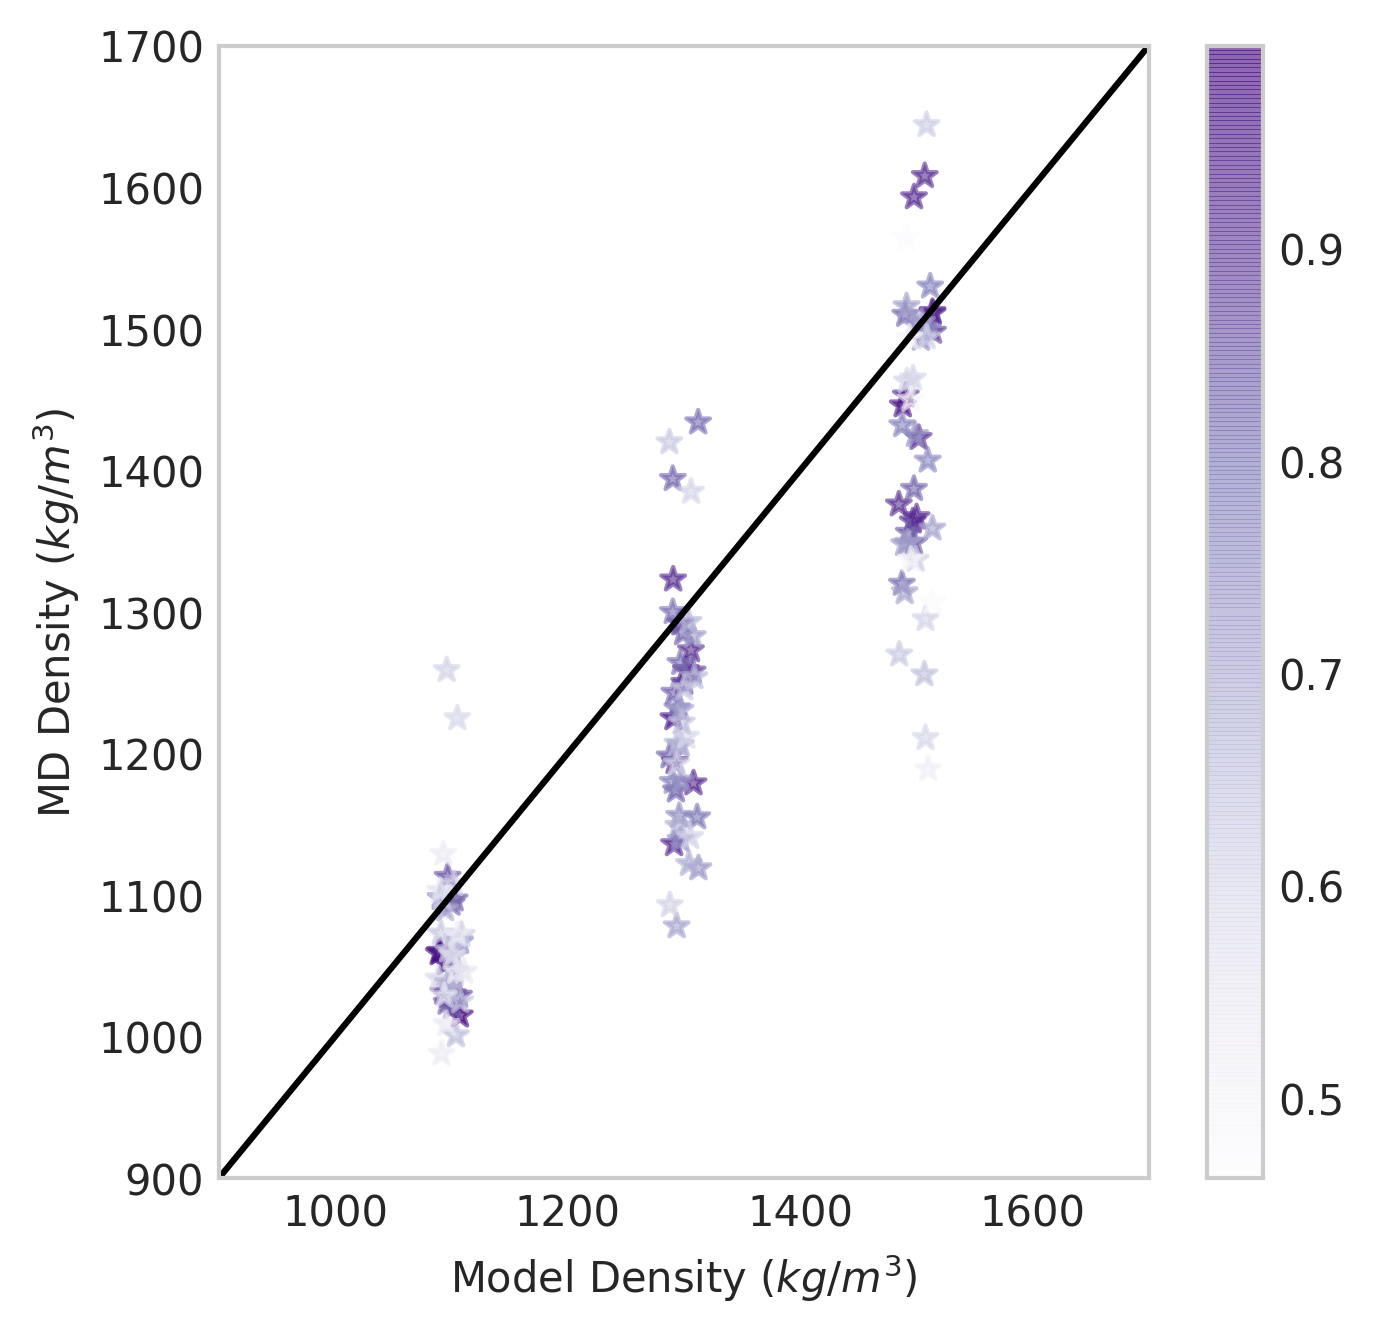

In [32]:
md = []
std = []
for i in range(out.shape[0]):
    md.append(float(out["MD Density"][i].split()[0]))
    std.append(float(out["MD Density"][i].split()[2]))
    
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax = fig.add_subplot(111)
    ax.errorbar(out["Model Density"], md, yerr=std, marker="*", linestyle="", alpha=0)
    scat = ax.scatter(out["Model Density"], md, marker="*", alpha=0.6,
               c=out["Tanimoto Similarity Score"], cmap="Purples")
    plt.colorbar(scat)
    ax.plot([900,1700], [900,1700], linestyle="-", label=None, c="black")
    ax.set_ylabel("MD Density $(kg/m^3)$")
    ax.set_xlabel("Model Density $(kg/m^3)$")
    plt.xlim(900,1700,200)
    plt.ylim(900,1700,200)
    ax.grid()
    
fig.savefig(filename='../../designer_molecules/proposed1.pdf', 
                       bbox_inches='tight', format='pdf') 

In [3]:
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as Calculator
from rdkit import Chem
cations = []
anions = []
for i in range(out.shape[0]):
    cations.append(out["Salt Smiles"][i].split(".")[0])
    anions.append(out["Salt Smiles"][i].split(".")[1])
###based on coco's Deslist
n = len(cations)
f = open('../salty/data/Deslist','r')
Deslist = []
for line in f:
    Deslist.append(line.strip('\n\t'))
calc = Calculator(Deslist)
d = len(Deslist)
for j, smiles in enumerate([cations, anions]):
    X = np.zeros((n,d+1))
    for i in range(n):
        ion = Chem.MolFromSmiles(smiles[i])
        X[i][1:]   = calc.CalcDescriptors(ion)
    cols = [s for s in Deslist]
    cols = ["smiles"] + cols
    X = pd.DataFrame(X, columns=cols)
    X.iloc[:,0] = smiles
    if j == 0:
        cations = X
    else:
        anions = X
cations.columns = [str(col) + '-cation' for col in cations.columns]
anions.columns = [str(col) + '-anion' for col in anions.columns]
new_df = pd.concat([anions, cations], axis = 1)
#Temp = 298.15; Pres = 101.325
new_df["Temperature, K"] = 298.15
new_df["Pressure, kPa"] = 101.325
new_df = new_df.select_dtypes(include=[np.number])

In [4]:
new_df["Specific density, kg/m<SUP>3</SUP>"] = "NaN"
for i in range(out.shape[0]):
    new_df["Specific density, kg/m<SUP>3</SUP>"][i] = float(out["MD Density"][i].split(" ")[0])

/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
scaled = new_df["Specific density, kg/m<SUP>3</SUP>"].apply(lambda x: log(float(x)))
new_df["Specific density, kg/m<SUP>3</SUP>"] = scaled

In [6]:
new_df = new_df.sample(frac=1)

In [7]:
data=np.array(new_df)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.75) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

deslist = genetic.load_data("density_m3_descriptors.csv")
X_train_gains = (X_train - deslist.iloc[0].values) / deslist.iloc[1].values
X_test_gains = (X_test - deslist.iloc[0].values) / deslist.iloc[1].values
Y_test_gains = Y_test
Y_train_gains = Y_train

In [8]:
property_model = "density"
pickle_in = open("../salty/data/MODELS/%s_devmodel.pkl" % property_model, "rb")
devmodel = dill.load(pickle_in)
rawdf = devmodel.Data
rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])
data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*1) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

In [9]:
X_train_combined = np.concatenate([X_train , X_train_gains])
Y_train_combined = np.concatenate([Y_train , Y_train_gains])
X_test_combined = np.concatenate([X_test, X_test_gains])
Y_test_combined = np.concatenate([Y_test, Y_test_gains])

In [10]:
X = X_train_combined
Y = Y_train_combined
#Density Model Settings
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
#Viscosity Model Settings
# model = MLPRegressor(activation='tanh', alpha=0.65795591411979337, batch_size='auto',
#        beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=25, learning_rate='invscaling',
#        learning_rate_init=0.001, max_iter=100000, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=None,
#        shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
#        verbose=False, warm_start=False)
model.fit(X,Y)
model.score(X,Y)

0.98959592546817476

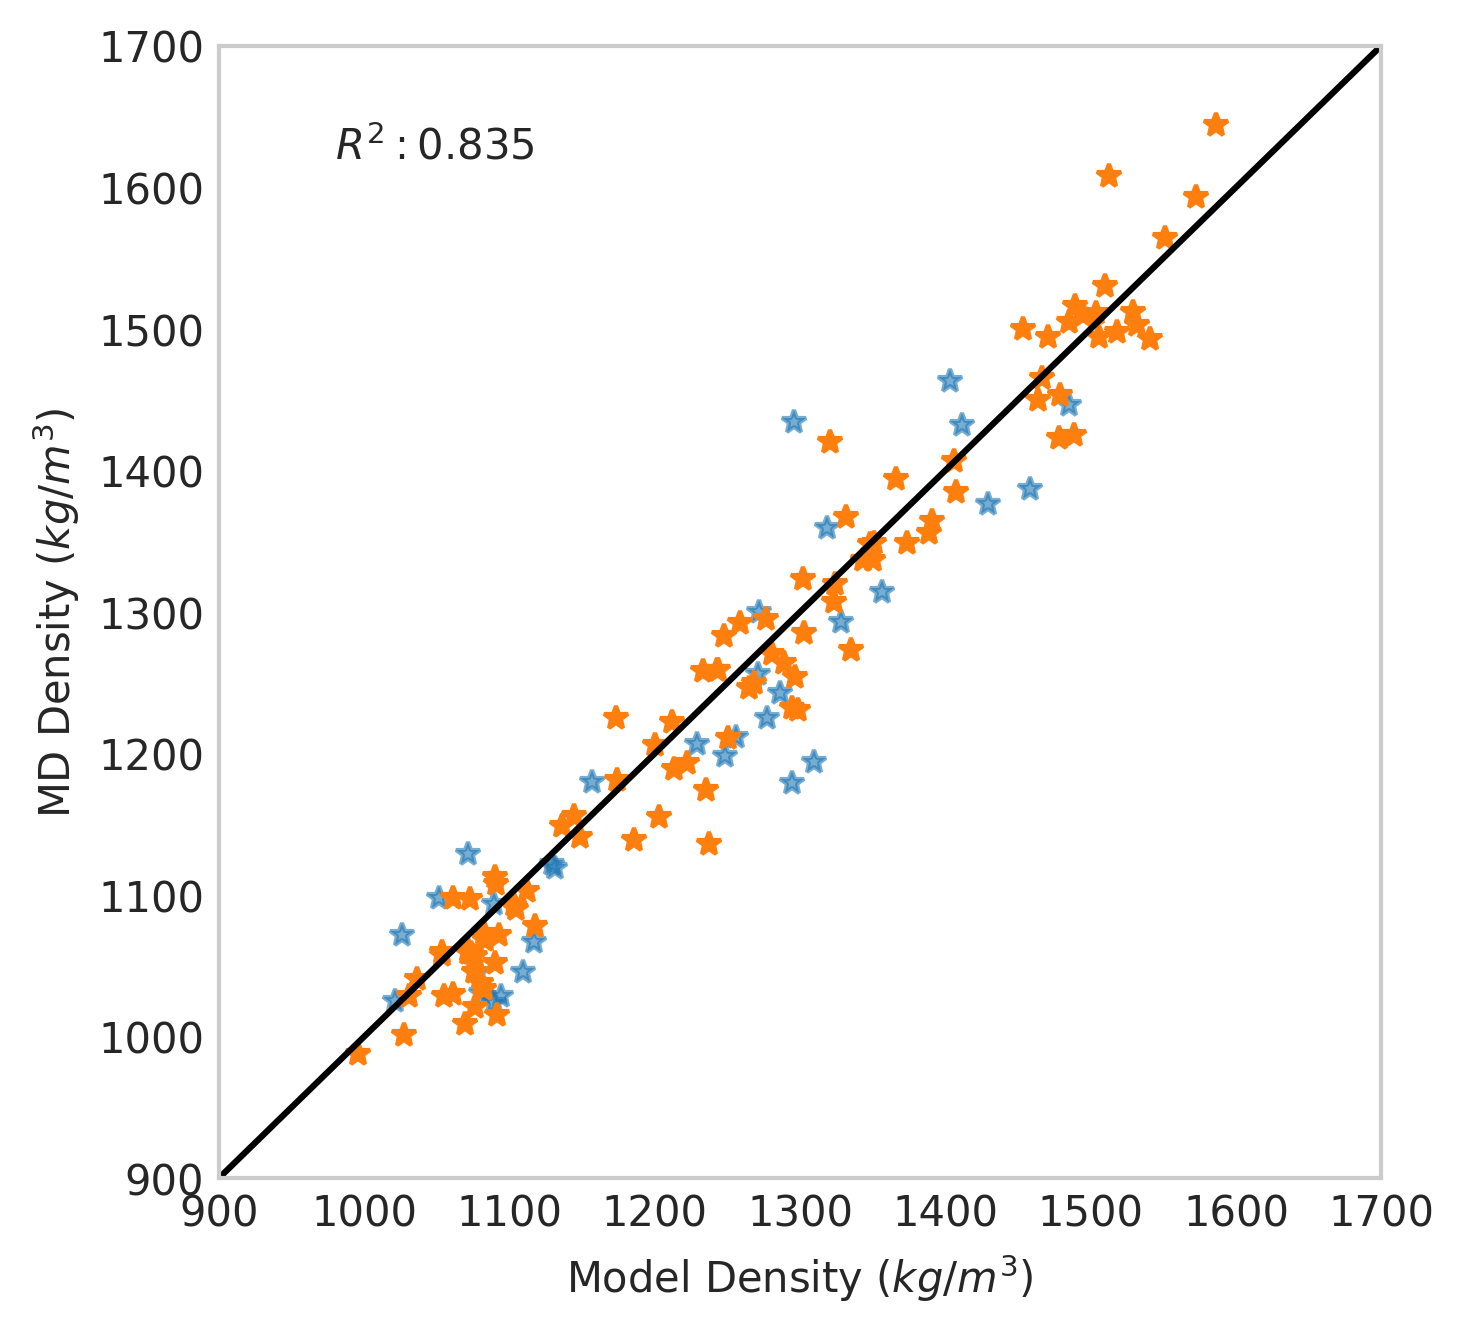

In [12]:
X = X_test_gains#np.concatenate([X_test_gains, X_train_gains])
Y = Y_test_gains#np.concatenate([Y_test_gains, Y_train_gains])

with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(np.exp(model.predict(X)),np.exp(Y),\
            marker="*",linestyle="",alpha=0.6,c=tableau20[0])
    ax.plot(np.exp(model.predict(X_train_gains)),np.exp(Y_train_gains),\
        marker="*",linestyle="",alpha=1,c=tableau20[2])
    ax.plot([900,1700], [900,1700], linestyle="-", label=None, c="black")
    ax.grid()
    ax.set_ylabel("MD Density $(kg/m^3)$")
    ax.set_xlabel("Model Density $(kg/m^3)$")
    plt.xlim(900,1700)
    plt.ylim(900,1700)
    ax.text(0.1,.9,"$R^2: ${0:5.3f}".format(model.score(X,Y)), transform = ax.transAxes)
    fig.savefig(filename='../../designer_molecules/proposed4.pdf', 
                       bbox_inches='tight', format='pdf') 

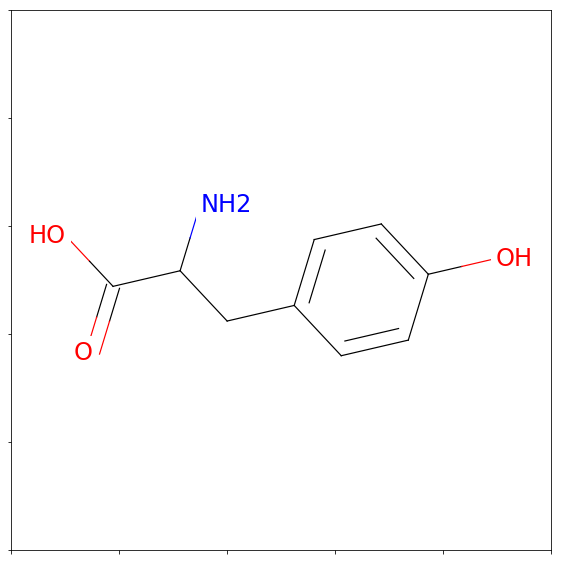

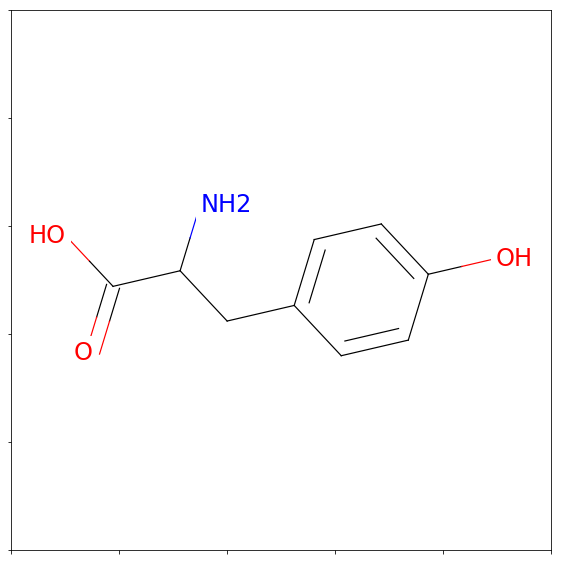

In [28]:
from rdkit.Chem import Draw
from rdkit import Chem
Draw.MolToMPL(Chem.MolFromSmiles("OC(=O)C(N)Cc1ccc(O)cc1"))